### Datasets
Zajmiemy się przetawrzaniem zbioru glass dostępny do pobrania tutaj http://archive.ics.uci.edu/ml/datasets/glass+identification
Jest to real life zbior danych ktory zawiera informacje o typie szkła i ilosci mineralow ktore zawiera.
przykladowo takie i inne zbior tez jest na kagglu ale nie ma wiecej info

To byl opis do glass, ale zmienilem na ecoli wiec trzeba opsiac ten http://archive.ics.uci.edu/ml/datasets/ecoli

We will perform the processing of ecoli dataset, available for download here: http://archive.ics.uci.edu/ml/datasets/ecoli.

Ecoli is a real-life dataset containting information about protein localization sites. The dataset contains 336 rows with 8 attributes. This is a multi-class problem.

In [12]:
import os
import numpy as np
from multi_imbalance.utils.min_int_maj import maj_int_min
seed = 0
np.random.seed(seed)

dataset_name = 'new_ecoli'
dir=os.getcwd() # te sciezkie potem poprawie, jak bedzie po releasie i w innym miejscu notebook


### Wczytanie danych
Rozpoczynamy od wczytania danych - mozemy do tego uzyc naszego utilla do wczytywania plikow typu arff
Mozemy uzyc naszeog utila do wczytywania arfow, dodatkowo za wczasu zrobi nam onehotencodera na zmiennych dyskretnych,
ustawi nam cechy najpierw ciagle a potem te zmodyfikowane one hot encoderem i powie nam ile mamy cech ciaglych do pozniejszej normalizacji

### Data loading
We begin with loading the data - it can be performed using the library's util for loading arff type files. The util loads arff files and performs onehotencoding for discrete variables.
The features will be ordered with all the continuous features first, followed by the ones modified by one hot encoder. It will also say how many continuous features there is for further normalization.

In [13]:
from multi_imbalance.utils.data import preprocess_dataset
X,y, cat = preprocess_dataset(f'{dir}/../data/arff/{dataset_name}.arff', return_cat_length=True)
print(X[:5])
print(y[:5])

[[0.49 0.29 0.48 0.5  0.56 0.24 0.35]
 [0.07 0.4  0.48 0.5  0.54 0.35 0.44]
 [0.56 0.4  0.48 0.5  0.49 0.37 0.46]
 [0.59 0.49 0.48 0.5  0.52 0.45 0.36]
 [0.23 0.32 0.48 0.5  0.55 0.25 0.35]]
[0 0 0 0 0]


Zbior ten charakteryzuje się wieloklasowym niezbalansowaniem
Mozemy go sobie zwizualizowac, zbior ma wiele wymiarow, do zredukowania wymiarow do 2 uzywamy PCA
(chociaz nie wiem czy to pisac)

This dataset is characterized by multi-class imbalance. To visualize, a dimension reduction technique needs to be applied, as this dataset has multiple dimensions. Here, for dimension recution, we use PCA.

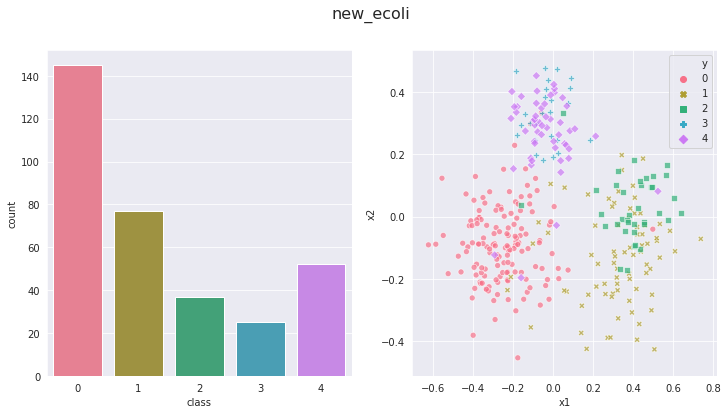

In [14]:
# TO sie wpakuje gdzies do funkcji, nie komentuj
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from multi_imbalance.utils.data import construct_flat_2pc_df

sns.set_style('darkgrid')

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches( 12, 6)
axs = axs.flatten()

axs[0].set_xlabel("class")
fig.suptitle(dataset_name, fontsize=16)

sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)

Widzimy, że zbiór jest niezbalansowany wieloklasowo, mamy dwie klasy ktore dominują 4 inne

### Przygotowanie danych do uczenia

W celu przygotowania danych do uczenia podzielimy zbior na dane uczace i testowe, nastepnie je znormalizujemy.
Uzyjemy w tym celu narzedzi dsotepnych w sklearn.

As shown above, there is multi-class imbalance in the dataset. There are two majority classes and 4 minority classes. 

### Data preparation

In order to prepare data for training, we will split the data for train and test subsets and normalize it. For both operations, we will use tools available in sklearn.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
if cat>0:
    scaler = StandardScaler()
    scaler.fit(X_train[:,:cat])

    X_train[:,:cat] = scaler.transform(X_train[:,:cat])
    X_test[:,:cat] = scaler.transform(X_test[:,:cat])



### Uczenie
Teraz cos napsiac ze sie uczymy, jako baseline/podstawowy kalsyfikator uzyjmey drzewa dostepna w sklearn

### Training

The training will be performed using a decision tree implementation from sklearn library.

In [16]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Do ewaluacji uzyjemy metryki gmean, cos powiedziec ze jest ona przeznacozna/dobra dla danych niezbalansowanych, bo
accuracy ssie (ale w filmie pominac w komentarzu bo bedzie we wstepie)

For evaluation, gmean metric will be used, as due to it's definition, it is a better fit for imbalanced data thatn accuracy.

In [17]:
from imblearn.metrics import geometric_mean_score
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.583'

Widzimy, jest dramat i tu wchodzimy my! No wlasnie jest dramat, bo w inzynierce mam tutaj 46%
### Resampling
Bierzemy SOUPa! SOUP to hybrydowa metoda preprocessingu danych, ktora wyznacza docelową licznosc klazzz a potem modyfikuje zbior danych tak aby osiagnac oczekiwane rozmiary klass
I tutaj zaladowalem to nasze maj_int_min bo to 5% daje xD
no i mozna powiedziec ze dodatkowo tutaj ladujemy slownik z informacjami ktore klasy sa mniejszosciowe, ale jest parametr opcjonalny i sluzy tylko do ustalenia docelowej licznosci, dodatkowo, ktora wersja lepsza? zaladowana czy wpisana explicite?

As we can see, the decision tree does not perform well for this type of problem. 

### Resampling

As a solution, we propose SOUP implementation. It is a hybrid data preprocessing method, which calculates the target class cardinality and modifies the dataset in order to match class sizes to the value previously calculated.
Additionally, a dictionary with minority classes can be passed to the method as a optional parameter. The dictionary will be used for calculating the target cardinality.

In [18]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP()
# X_train_res, y_train_res = soup.fit_transform(X_train, y_train, maj_int_min=maj_int_min[dataset_name])
X_train_res, y_train_res = soup.fit_transform(X_train, y_train, maj_int_min={'maj': [0, 1], 'int': [], 'min': [4, 2, 3]},)

Powtarzamy obliczenia ale tym razem na zmodyfikowanych danych

We perform the calculations once again with modified data.

In [19]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.624'

Mjut malina! Moze i 18% ale to 3 razy lepiej, dostroimy. Poza metodami preprocessingu dostepnymi w multi-imbalance
dostepne sa rowniez algorytmu do enseblingu?? danych.

### Ensemble
W naszym przypadku uzyjemy OVO. OVO jest metodą dekompozycji gdzie tworzymy pary kazdy z kazdym, tak trenujemy klasyfikatory ktore potem glosuja na decyzje. OVO w naszym pakiecie jest superasne bo mozemy wrzucac do niego dowolne klasfyikatory m.in z sklearna ktore implementuja odpowiednie metody (jakos tak ladnie to czeba) i tak samo z metodami resamplingu! Resampling dzieje się miedzy parami
( w sensie ze robimy pare i per para jest resampling za akzdym razem, to trzeba jakos zwiezle i ladnie i moze rozbic)
W naszym przykladzie do resamplingu uzyjemy soupa bo supcio dzialal

As we can see, the preprocessing of the data improved the performance significantly. 
In the library there two types of methods implemented: preprocessing methods and ensemble methods.

### Ensemble
In this case, OVO implementation will be used. OVO is a data decomposition method, where classes are paired in all possible configurations and the paires are used to train classifiers, which vote for the final decision. OVO implementation in our libray allows the use of any type of classifier with interface compatible with sklearn convention. The same applies for resampling methods. Resampling is applied to pairs decomposed from the original data.
In this use case, SOUP will be used for resampling.

In [20]:
from multi_imbalance.ensemble.ovo import OVO

clf = OVO(
    binary_classifier=DecisionTreeClassifier(random_state=seed),
    preprocessing=SOUP()
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.665'

Czy to jest ok jak SOUP wyszedl nieco lepiej niz OVO? no i tak poprawia znaczaco

As shown above, the OVO ensemble method along with SOUP resampling further improves the performance of the decision tree.